# Rotate images
[Rotate images (correctly) with OpenCV and Python
](https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/)

In [1]:
import os
os.environ["OPENBLAS_CORETYPE"] ="Skylake"
os.getenv("OPENBLAS_CORETYPE")

import numpy as np
import cv2
from PIL import Image

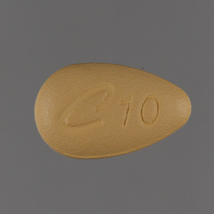

In [2]:
image = cv2.imread('img/rotate/pill_01.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # or numpy:
Image.fromarray(image)

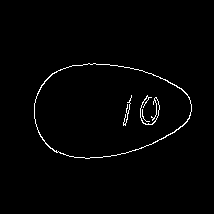

In [3]:
image = cv2.imread('img/rotate/pill_01.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)
edged = cv2.Canny(gray, 20, 100)
Image.fromarray(edged)

In [4]:
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] #points coordinates only, no hierarchy 

In [5]:
# ensure at least one contour was found
if len(cnts) > 0:
	# grab the largest contour, then draw a mask for the pill
	c = max(cnts, key=cv2.contourArea)

	mask = np.zeros(gray.shape, dtype="uint8")
	cv2.drawContours(mask, [c], -1, 255, -1)  # last arg - thikness (-1 :fillall)
	# compute its bounding box of pill, then extract the ROI,
	# and apply the mask
	(x, y, w, h) = cv2.boundingRect(c)
	imageROI = image[y:y + h, x:x + w]
	maskROI = mask[y:y + h, x:x + w]
	imageROI = cv2.bitwise_and(imageROI, imageROI, mask=maskROI)

print(x,y,w,h)

34 63 158 96


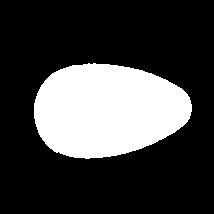

In [6]:
Image.fromarray(mask)

In [7]:
def rotate(image, angle, center=None, scale=1.0):
    # grab the dimensions of the image
    (h, w) = image.shape[:2]

    # if the center is None, initialize it as the center of
    # the image
    if center is None:
        center = (w // 2, h // 2)

    # perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    # return the rotated image
    return rotated

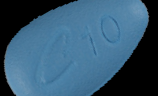

In [8]:
angle = 30
rotated = rotate(imageROI, angle)
Image.fromarray(rotated)

In [9]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

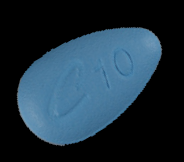

In [10]:
angle = -30
rot = rotate_bound(imageROI, angle)
Image.fromarray(rot)

## Appendix: findContours

You are supposed to invert the binary image and then perform contour operations. This is because the contours are formed only around the white regions.

```python
contours, hierarchy = cv2.findContours(image, mode, method)
```
mode:
* `CV_RETR_EXTERNAL` - gives "outer" contours, so if you have (say) one contour enclosing another (like concentric circles), only the outermost is given.

* `CV_RETR_LIST` - gives all the contours and doesn't even bother calculating the hierarchy - good if you only want the contours and don't care whether one is nested inside another.

* `CV_RETR_CCOMP` - retrieves all of the contours and organizes them into a two-level hierarchy. At the top level, there are external boundaries of the components. At the second level, there are boundaries of the holes. If there is another contour inside a hole of a connected component, it is still put at the top level.

* `CV_RETR_TREE` - calculates the full hierarchy of the contours. So you can say that object1 is nested 4 levels deep within object2 and object3 is also nested 4 levels deep.

method:
* `cv2.CHAIN_APPROX_NONE` - zwraca całe linie
* `cv2.CHAIN_APPROX_SIMPLE` - zwraca punkty skrajne
* `cv2.CHAIN_APPROX_TC89_L1`


Współrzędne konturów są zapisane jako (X, Y)

* contours - informacje o współrzędnych
* hierarchy- informacje o hierarchii

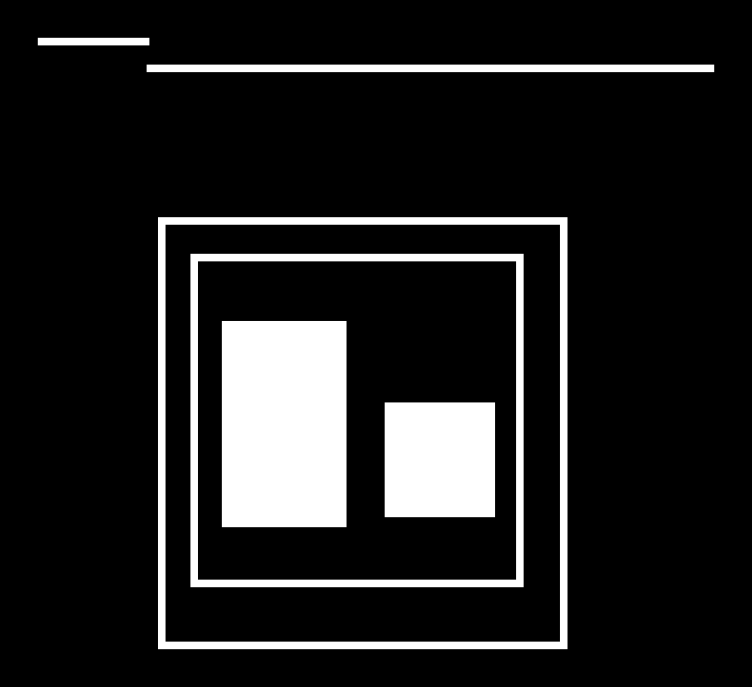

In [11]:
img = cv2.imread('img/rotate/cnt.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.bitwise_not(img)
Image.fromarray(img)

Object 0
[157, 217]
[157, 648]
[158, 649]
[567, 649]
[567, 217]
Object 1
[165, 225]
[166, 224]
[558, 224]
[559, 225]
[559, 640]
[558, 641]
[166, 641]
[165, 640]
Object 2
[190, 253]
[190, 587]
[523, 587]
[523, 253]
Object 3
[197, 262]
[198, 261]
[515, 261]
[516, 262]
[516, 578]
[515, 579]
[198, 579]
[197, 578]
Object 4
[384, 402]
[384, 517]
[495, 517]
[495, 402]
Object 5
[221, 320]
[221, 527]
[346, 527]
[346, 320]
Object 6
[146, 64]
[146, 72]
[714, 72]
[714, 64]
Object 7
[37, 37]
[37, 45]
[149, 45]
[149, 37]


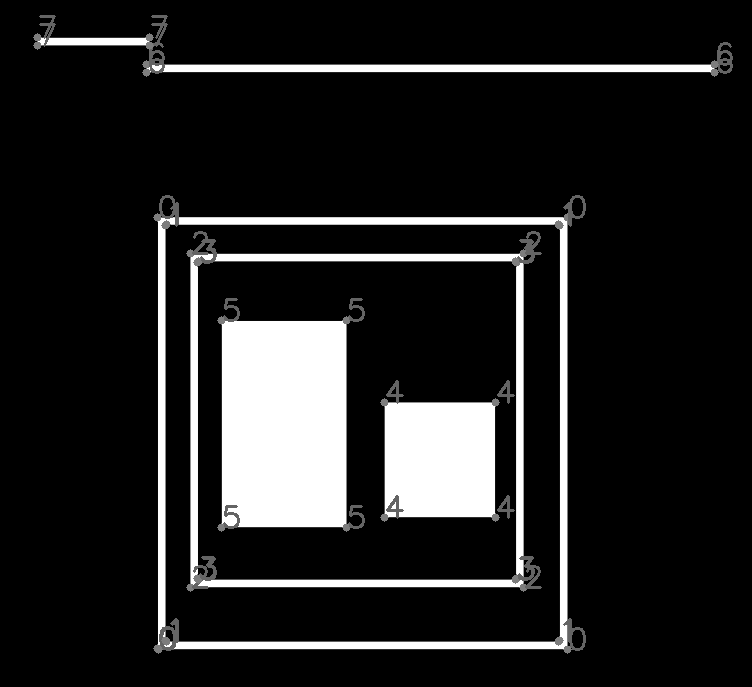

In [12]:
import itertools

def contours(mode = cv2.RETR_LIST, aprox = cv2.CHAIN_APPROX_SIMPLE):
    return cv2.findContours(img.copy(), mode, aprox)

# cnts = contours(cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)  # 3 obiekty
# cnts = contours(cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)  # 8 obiektów
# cnts = contours(cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)  # 8 obiektów
cnts = contours(cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  # 8 obiektów 
# print(cnts)
dots = img.copy()

for i in range(len(cnts[0])):
    print('Object', i)
    for j in range(len(cnts[0][i])):
        xy = cnts[0][i][j].tolist()
        flattened_list  = list(itertools.chain(*xy))
        x,y = flattened_list[0], flattened_list[1]
        
        dots = cv2.circle(dots, (x,y), 4, (125,0,0), -1)
        cv2.putText(dots, str(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (100,100,100), 2)

        print(flattened_list)

Image.fromarray(dots)

In [13]:
cnts = contours(cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# cnts = contours(cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

for (i, c) in enumerate(cnts[0]):
    print("\tSize of contour %d: %d" % (i, len(c)))

	Size of contour 0: 5
	Size of contour 1: 8
	Size of contour 2: 4
	Size of contour 3: 8
	Size of contour 4: 4
	Size of contour 5: 4
	Size of contour 6: 4
	Size of contour 7: 4


In [14]:
# Hierarchia obiektow
# [Next (same level), Previous (same level), First_Child, Parent]
print(cnts[1])

[[[ 6 -1  1 -1]
  [-1 -1  2  0]
  [-1 -1  3  1]
  [-1 -1  4  2]
  [ 5 -1 -1  3]
  [-1  4 -1  3]
  [ 7  0 -1 -1]
  [-1  6 -1 -1]]]


In [15]:
# Posortuj kontury po wielkości obszaru i ogranicz się do 2 największych 

ct = sorted(cnts[0], key = cv2.contourArea, reverse = True)[:2]
print(ct)

# Wybierz bezpośrednio najwiekszy kontur
c = max(cnts[0], key=cv2.contourArea)
print(c)

[array([[[157, 217]],

       [[157, 648]],

       [[158, 649]],

       [[567, 649]],

       [[567, 217]]], dtype=int32), array([[[165, 225]],

       [[166, 224]],

       [[558, 224]],

       [[559, 225]],

       [[559, 640]],

       [[558, 641]],

       [[166, 641]],

       [[165, 640]]], dtype=int32)]
[[[157 217]]

 [[157 648]]

 [[158 649]]

 [[567 649]]

 [[567 217]]]
